# 데이터 로딩

In [ ]:
# 한글 깨짐 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,766 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and dire

In [ ]:
# 한글깨짐 방지(2) - 런타임 재시작 유도 코드 (session crashed 메세지창 무시)
import os
os.kill(os.getpid(), 9)

In [ ]:
# 필요한 라이브러리 & 기본 세팅
import numpy as np
import pandas as pd
# 소수점 아래 한자리 수까지 표시
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
%matplotlib inline

In [187]:
# 데이터 로드
## read_csv 할 때부터 datetime object로 읽어들이기
train = pd.read_csv('https://raw.githubusercontent.com/jparkgit/ESAA-23-2/main/data/movies/train.csv', sep = ',', parse_dates = ['release_time'])
test = pd.read_csv('https://raw.githubusercontent.com/jparkgit/ESAA-23-2/main/data/movies/test.csv', sep = ',', parse_dates = ['release_time'])
submission = pd.read_csv('https://raw.githubusercontent.com/jparkgit/ESAA-23-2/main/data/movies/submission.csv', sep = ',')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSE: {0:.3f}, MAE: {1:.3f}'.format(rmse_val, mae_val))

Dataset 내용
+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [188]:
# 월, 년도 열 생성
train['release_year'] = train['release_time'].dt.year
train['release_month'] = train['release_time'].dt.month
test['release_year'] = test['release_time'].dt.year
test['release_month'] = test['release_time'].dt.month
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2012,11
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.500,2,387,3,7072501,2015,11
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.250,4,343,4,6959083,2013,6
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.000,2,20,6,217866,2012,7
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.000,1,251,2,483387,2010,11


train과  test 모두 dir_prev_bfnum이 결측값으로 존재하는 데이터들은 전부 dir_prev_num이 0인 영화들이다. 즉, 감독의 이전작품이 존재 하지 않은 경우이다. 따라서 dir_prev_bfnum에 있는 결측값은 전부 0으로 채운다.

In [189]:
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [190]:
y_target = train['box_off_num']
# 'title', 'box_off_num' 은 인코딩할 때 필요해서 나중에 지우기
X_features = train.drop(['release_time'], axis=1, inplace=False)
X_test = test.drop(['release_time'], axis=1, inplace=False)

<Axes: >

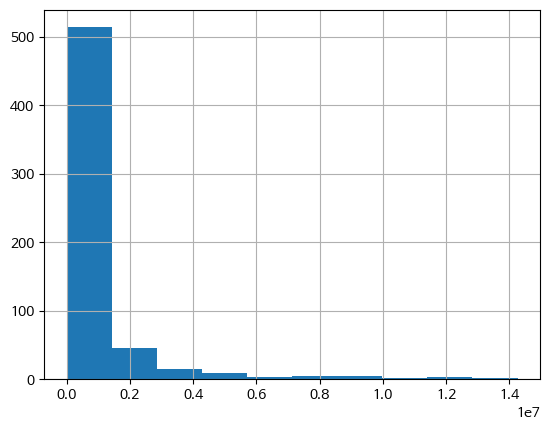

In [182]:
y_target.hist()

<Axes: >

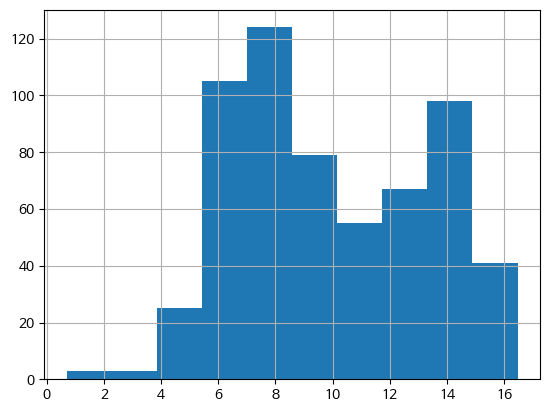

In [191]:
# y 타깃 로그 변환
log_y = np.log1p(y_target)
log_y.hist()

#카테고리 피처 인코딩

카테고리형 변수 (4): 'distributor', 'genre, 'screening_rat', 'director', 'release_year', 'release_month'
1. 'director' 삭제
2. 'distributor': 중앙값 이상 배급사와 그 외 배급사 랭크 인코딩
3. 'genre', 'screening_rat': 랭크 인코딩
4. 'release_year', 'release_month': 랭크 인코딩


## (1) 'director' 삭제

In [192]:
X_features1= X_features.copy()
X_features1.drop(['director'], axis=1, inplace=True)
X_test1 = X_test.copy()
X_test1.drop(['director'], axis=1, inplace=True)

In [193]:
X_features2= X_features1.copy()
X_test2= X_test1.copy()
X_features3= X_features1.copy()
X_test3= X_test1.copy()
X_features4a= X_features1.copy()
X_test4a= X_test1.copy()
X_features4b= X_features1.copy()
X_test4b= X_test1.copy()
X_features4c= X_features1.copy()
X_test4c= X_test1.copy()

'title', 'box_off_num' 삭제 안 된 상태

## (2) 'distributor': 중앙값 이상 배급사와 그 외 배급사 랭크 인코딩

In [ ]:
X_features2.groupby('distributor')['title'].count().sort_values(ascending=False)

distributor
CJ 엔터테인먼트    54
롯데엔터테인먼트     52
(주)NEW       30
(주)마운틴픽쳐스    29
(주)쇼박스       26
             ..
새인컴퍼니         1
상구네 필름        1
사람과 사람들       1
보람엔터테인먼트      1
마법사필름         1
Name: title, Length: 169, dtype: int64

In [207]:
# 배급사 별 영화수와 총 관객수 정보를 담은 데이터 프레임
distributors = X_features1.groupby('distributor').sum()
distributors['count'] = X_features1.groupby('distributor').count()['title']
distributors.reset_index(inplace=True)
distributors = distributors[['distributor','count', 'box_off_num']]
sorted_dist = distributors.sort_values('box_off_num',ascending=False)
sorted_dist

<ipython-input-207-e1cfe05a6ab0>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  distributors = X_features1.groupby('distributor').sum()


,distributor,count,box_off_num
51,CJ 엔터테인먼트,54,116788093
21,(주)쇼박스,26,88053064
6,(주)NEW,30,65532145
80,롯데엔터테인먼트,52,64383745
49,CJ E&M Pictures,2,8244674
...,...,...,...
68,나우콘텐츠,1,54
131,위드시네마,1,46
92,사람과 사람들,1,42
65,고구마공작소,1,8


<Axes: xlabel='count', ylabel='box_off_num'>

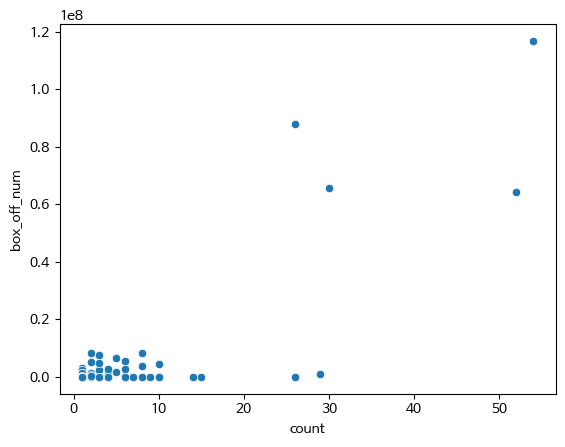

In [208]:
import seaborn as sns
sns.scatterplot(x='count', y='box_off_num', data=distributors)

In [209]:
# 눈에 띄게 관객수와 영화 수 높은 배급사 4개
sorted_dist[:4]['distributor']

51    CJ 엔터테인먼트
21       (주)쇼박스
6        (주)NEW
80     롯데엔터테인먼트
Name: distributor, dtype: object

<Axes: xlabel='count', ylabel='box_off_num'>

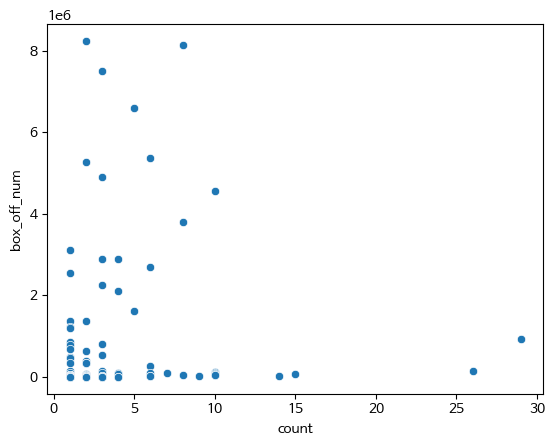

In [210]:
# 4개 제외한 배급사들
rest_dist = distributors.sort_values('box_off_num',ascending=False)[4:]
sns.scatterplot(x='count', y='box_off_num', data=rest_dist)

In [211]:
# 관객수도 많고 영화수도 많은 배급사들
sorted_dist_count_med = sorted_dist['count'].median()
sorted_dist_bf_med = sorted_dist['box_off_num'].median()

sorteddist_abovemed = sorted_dist[(sorted_dist['count'] > sorted_dist_count_med) & (sorted_dist['box_off_num'] > sorted_dist_bf_med)]
sorteddist_abovemed.shape

(55, 3)

In [212]:
sorteddist_abovemed.head()

,distributor,count,box_off_num
51,CJ 엔터테인먼트,54,116788093
21,(주)쇼박스,26,88053064
6,(주)NEW,30,65532145
80,롯데엔터테인먼트,52,64383745
49,CJ E&M Pictures,2,8244674


<Axes: xlabel='count', ylabel='box_off_num'>

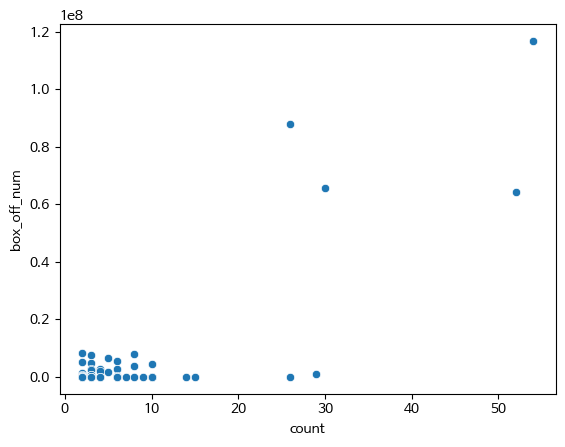

In [213]:
sns.scatterplot(x='count', y='box_off_num', data=sorteddist_abovemed)

In [214]:
topdist_list = sorteddist_abovemed['distributor'].tolist()
print(topdist_list)
print(len(topdist_list))

['CJ 엔터테인먼트', '(주)쇼박스', '(주)NEW', '롯데엔터테인먼트', 'CJ E&M Pictures', 'NEW', 'CJ E&M 영화부문', 'CGV아트하우스', '시네마서비스', '쇼박스(주)미디어플렉스', '이십세기폭스코리아(주)', '시너지', '인벤트 디', '씨너스엔터테인먼트(주)', '싸이더스', '필라멘트 픽쳐스', '씨네그루(주)키다리이엔티', '메가박스(주)플러스엠', '리틀빅픽처스', 'CGV 아트하우스', '(주)마운틴픽쳐스', 'KT', '리틀빅픽쳐스', '(주)마인스 엔터테인먼트', '(주)리틀빅픽처스', '화앤담이엔티', '(주)프레인글로벌', '무비꼴라쥬', '(주) 영화제작전원사', '인디스토리', '시네마달', '나이너스엔터테인먼트(주)', '스폰지', '타임스토리그룹', '영화사 진진', 'BoXoo 엔터테인먼트', 'SBS콘텐츠허브', '(주) 영화사조제', '골든타이드픽처스', '(주)엣나인필름', '어뮤즈', '백두대간', 'KT&G 상상마당', '에스피엠', '(주)키노아이', '(주)마인스엔터테인먼트', '파이오니아21', '인디플러그', '(주)시네마달', '시네마 달', '(주)팝엔터테인먼트', '조이앤시네마', '(주)스톰픽쳐스코리아', '김기덕 필름', '(주) 케이알씨지']
55


In [217]:
print(topdist_list[0])
print(topdist_list[54])

CJ 엔터테인먼트
(주) 케이알씨지


In [218]:
def abovemeddist(data):
  if data['distributor'] in topdist_list:
    rank = 1 + topdist_list.index(data['distributor'])
    return rank
  else:
    return 57

X_features2['dist_abovemed'] = X_features2.apply(abovemeddist, axis=1)
X_test2['dist_abovemed'] = X_test2.apply(abovemeddist, axis=1)
X_features2.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,dist_abovemed
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.000,0,91,2,23398,2012,11,4
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.500,2,387,3,7072501,2015,11,2
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.250,4,343,4,6959083,2013,6,2
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.000,2,20,6,217866,2012,7,3
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.000,1,251,2,483387,2010,11,10


In [219]:
X_features2.drop(['distributor'], axis=1, inplace=True)
X_test2.drop(['distributor'], axis=1, inplace=True)

## (3) 'genre', 'screening_rat': 랭크 인코딩

In [225]:
genre_df = X_features3.groupby('genre').sum().reset_index()[['genre','box_off_num']].sort_values('box_off_num',ascending=False)
genre_df

<ipython-input-225-38be87bff9ad>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_df = X_features3.groupby('genre').sum().reset_index()[['genre','box_off_num']].sort_values('box_off_num',ascending=False)


,genre,box_off_num
4,드라마,138277444
11,코미디,63277442
10,액션,61711274
2,느와르,61119768
5,멜로/로맨스,33225507
1,공포,24814966
0,SF,23248494
7,미스터리,8968319
3,다큐멘터리,6247020
9,애니메이션,3820460


In [226]:
screen_rat_df = X_features3.groupby('screening_rat').sum().reset_index()[['screening_rat','box_off_num']].sort_values('box_off_num',ascending=False)
screen_rat_df

<ipython-input-226-0c02ad6dcb28>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  screen_rat_df = X_features3.groupby('screening_rat').sum().reset_index()[['screening_rat','box_off_num']].sort_values('box_off_num',ascending=False)


,screening_rat,box_off_num
1,15세 관람가,251998766
0,12세 관람가,86188052
3,청소년 관람불가,74292991
2,전체 관람가,12429242


In [227]:
screen_rat_df['screening_rat'].tolist().index('12세 관람가')

1

In [228]:
def genre_rank(data):
  if data['genre'] in genre_df['genre'].tolist():
    rank = 1+ genre_df['genre'].tolist().index(data['genre'])
    return rank
  else:
    return 'error'

X_features3['genre_rank'] = X_features3.apply(genre_rank, axis=1)
X_test3['genre_rank'] = X_test3.apply(genre_rank, axis=1)
X_features3.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,genre_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.000,0,91,2,23398,2012,11,3
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.500,2,387,3,7072501,2015,11,4
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.250,4,343,4,6959083,2013,6,3
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.000,2,20,6,217866,2012,7,2
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.000,1,251,2,483387,2010,11,2


In [229]:
def screening_rat_rank(data):
  if data['screening_rat'] in screen_rat_df['screening_rat'].tolist():
    rank = 1+ screen_rat_df['screening_rat'].tolist().index(data['screening_rat'])
    return rank
  else:
    return 'error'

X_features3['screening_rat_rank'] = X_features3.apply(screening_rat_rank, axis=1)
X_test3['screening_rat_rank'] = X_test3.apply(screening_rat_rank, axis=1)
X_features3.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,genre_rank,screening_rat_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.000,0,91,2,23398,2012,11,3,3
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.500,2,387,3,7072501,2015,11,4,3
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.250,4,343,4,6959083,2013,6,3,1
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.000,2,20,6,217866,2012,7,2,4
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.000,1,251,2,483387,2010,11,2,1


In [230]:
print(X_features3['genre_rank'].unique())
print(X_features3['screening_rat_rank'].unique())

[ 3  4  2  9 12  1  5  6 11 10  8  7]
[3 1 4 2]


## (4) 'release_year', 'release_month': 랭크 인코딩

In [233]:
year_df = X_features4a.groupby('release_year').sum().reset_index()[['release_year','box_off_num']].sort_values('box_off_num',ascending=False)
year_df

<ipython-input-233-27cbc7e31a9d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_df = X_features4a.groupby('release_year').sum().reset_index()[['release_year','box_off_num']].sort_values('box_off_num',ascending=False)


,release_year,box_off_num
3,2013,95698992
2,2012,83223817
4,2014,75423331
5,2015,71504305
1,2011,50309371
0,2010,48749235


In [234]:
def year_rank(data):
  if data['release_year'] in year_df['release_year'].tolist():
    rank = 1+ year_df['release_year'].tolist().index(data['release_year'])
    return rank
  else:
    return 'error'

X_features4a['year_rank'] = X_features4a.apply(year_rank, axis=1)
X_test4a['year_rank'] = X_test4a.apply(year_rank, axis=1)
X_features4a.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,year_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.000,0,91,2,23398,2012,11,2
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.500,2,387,3,7072501,2015,11,4
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.250,4,343,4,6959083,2013,6,1
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.000,2,20,6,217866,2012,7,2
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.000,1,251,2,483387,2010,11,6


In [235]:
month_df = X_features4a.groupby('release_month').sum().reset_index()[['release_month','box_off_num']].sort_values('box_off_num',ascending=False)
month_df

<ipython-input-235-9182a3356874>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month_df = X_features4a.groupby('release_month').sum().reset_index()[['release_month','box_off_num']].sort_values('box_off_num',ascending=False)


,release_month,box_off_num
11,12,63124139
7,8,56603892
6,7,54576555
0,1,53271292
8,9,43891718
10,11,35687080
4,5,32814059
9,10,23154249
1,2,20553781
5,6,14856308


In [236]:
def month_rank(data):
  if data['release_month'] in month_df['release_month'].tolist():
    rank = 1+ month_df['release_month'].tolist().index(data['release_month'])
    return rank
  else:
    return 'error'

X_features4a['month_rank'] = X_features4a.apply(month_rank, axis=1)
X_test4a['month_rank'] = X_test4a.apply(month_rank, axis=1)
X_features4a.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,year_rank,month_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.000,0,91,2,23398,2012,11,2,6
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.500,2,387,3,7072501,2015,11,4,6
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.250,4,343,4,6959083,2013,6,1,10
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.000,2,20,6,217866,2012,7,2,3
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.000,1,251,2,483387,2010,11,6,6


In [237]:
print(X_features4a['year_rank'].unique())
print(X_features4a['month_rank'].unique())

[2 4 1 6 3 5]
[ 6 10  3  8  7  5 11 12  2  9  1  4]


## 라벨 인코딩

In [262]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_features_le = X_features1.copy()
X_test_le= X_test1.copy()
X_features_le.drop(['title', 'box_off_num'], axis=1, inplace=True)
X_test_le.drop(['title'], axis=1, inplace=True)
items = X_features_le[['distributor','genre', 'screening_rat', 'release_year', 'release_month']]
for i in items:
 X_features_le[i] = le.fit_transform(X_features_le[i])
items = X_test_le[['distributor','genre', 'screening_rat', 'release_year', 'release_month']]
for i in items:
 X_test_le[i] = le.fit_transform(X_test_le[i])


In [163]:
X_features_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    int64  
 1   genre           600 non-null    int64  
 2   time            600 non-null    int64  
 3   screening_rat   600 non-null    int64  
 4   dir_prev_bfnum  600 non-null    float64
 5   dir_prev_num    600 non-null    int64  
 6   num_staff       600 non-null    int64  
 7   num_actor       600 non-null    int64  
 8   release_year    600 non-null    int64  
 9   release_month   600 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 47.0 KB


In [264]:
X_test_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     243 non-null    int64  
 1   genre           243 non-null    int64  
 2   time            243 non-null    int64  
 3   screening_rat   243 non-null    int64  
 4   dir_prev_bfnum  243 non-null    float64
 5   dir_prev_num    243 non-null    int64  
 6   num_staff       243 non-null    int64  
 7   num_actor       243 non-null    int64  
 8   release_year    243 non-null    int64  
 9   release_month   243 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 19.1 KB


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: title={'center': 'Absolute Pearson Correalation of All Features'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


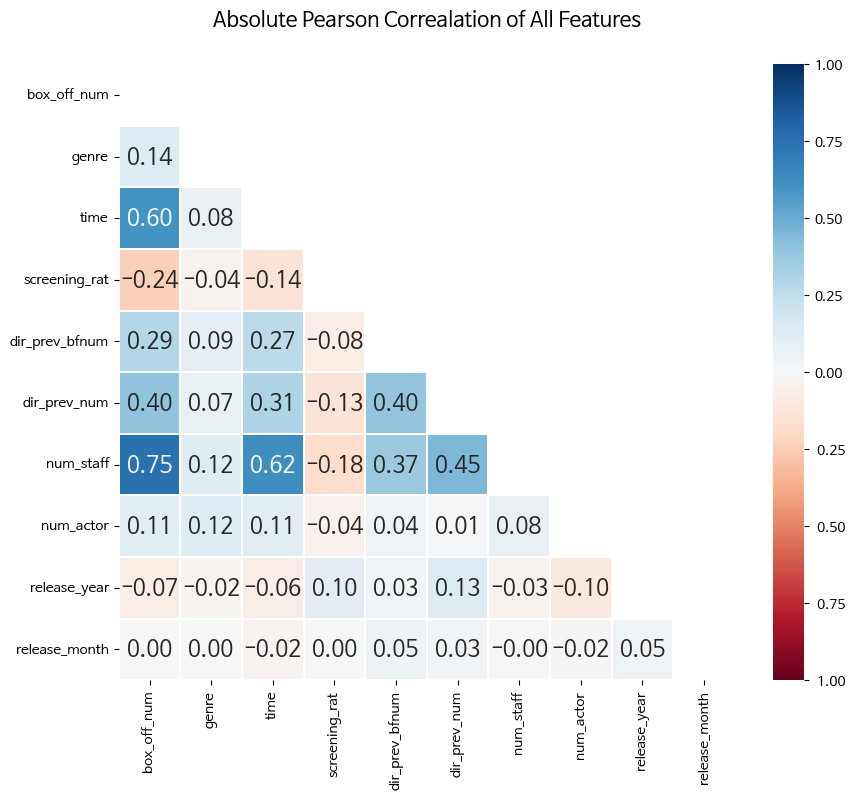

In [ ]:
heatmap_data1 = pd.concat([log_y, X_features_le], axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 8))

plt.title('Absolute Pearson Correalation of All Features', y=1.05, size=15)
corr = heatmap_data1.corr()
# Getting the Upper Triangle of the co-relation matrix
upper = np.triu(corr)

sns.heatmap(corr, linewidths=0.1, vmin = -1.0, vmax=1.0, square=True, mask=upper,
            cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16}, fmt='.2f')

In [239]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [240]:
# 라벨 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features_le, log_y,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환, log 변환된거 고려하는
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  y_test = np.expm1(y_test)
  pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test)

### LinearRegression ###
RMSE: 27050440.962, MAE: 3068890.505
### Ridge ###
RMSE: 27262792.423, MAE: 3092286.657
### Lasso ###
RMSE: 27821987.902, MAE: 3140172.597


# 연속형 피처들 로그 변환

피처 11개
* 카테고리형 변수 (6): 'distributor', 'genre, 'screening_rat', 'director', 'release_year', 'release_month'
* 연속형 변수 (5): 'time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor'

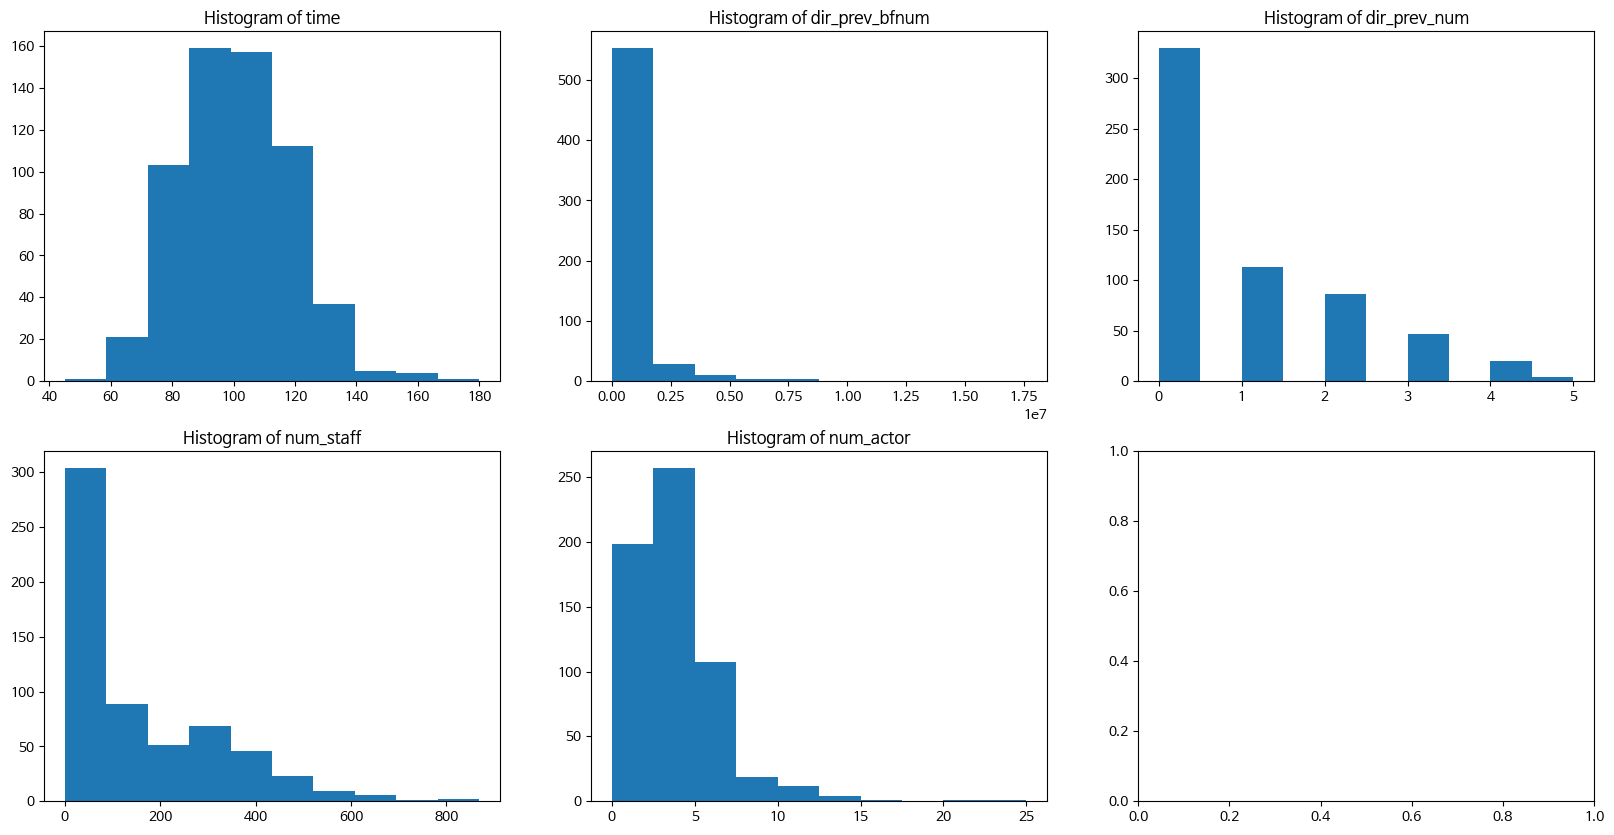

In [241]:
conti_features = ['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']

#import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (20, 10), nrows = 2, ncols = 3)
axs = np.ravel(axs)

for ind, feature in enumerate(conti_features):
  axs[ind].set_title(f"Histogram of {feature}")
  axs[ind].hist(X_features[feature])
  #sns.kdeplot(train[list[i]], fill = True)
  #plt.title(f"Density Plot of {list[i]}")
  #plt.xlabel(f"{list[i]}")

axs = np.reshape(axs, (2, 3))

In [242]:
from scipy.stats import skew

skew_features = X_features[conti_features].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

dir_prev_bfnum   6.173
num_actor        2.943
dir_prev_num     1.250
num_staff        1.230
dtype: float64


In [243]:
X_features_log = X_features1.copy()
log_conti_features = ['log_time', 'log_dir_prev_bfnum','log_dir_prev_num', 'log_num_staff', 'log_num_actor']
X_features_log[log_conti_features] = np.log1p(X_features_log[conti_features])
X_test_log = X_test1.copy()
log_conti_features = ['log_time', 'log_dir_prev_bfnum','log_dir_prev_num', 'log_num_staff', 'log_num_actor']
X_test_log[log_conti_features] = np.log1p(X_test_log[conti_features])

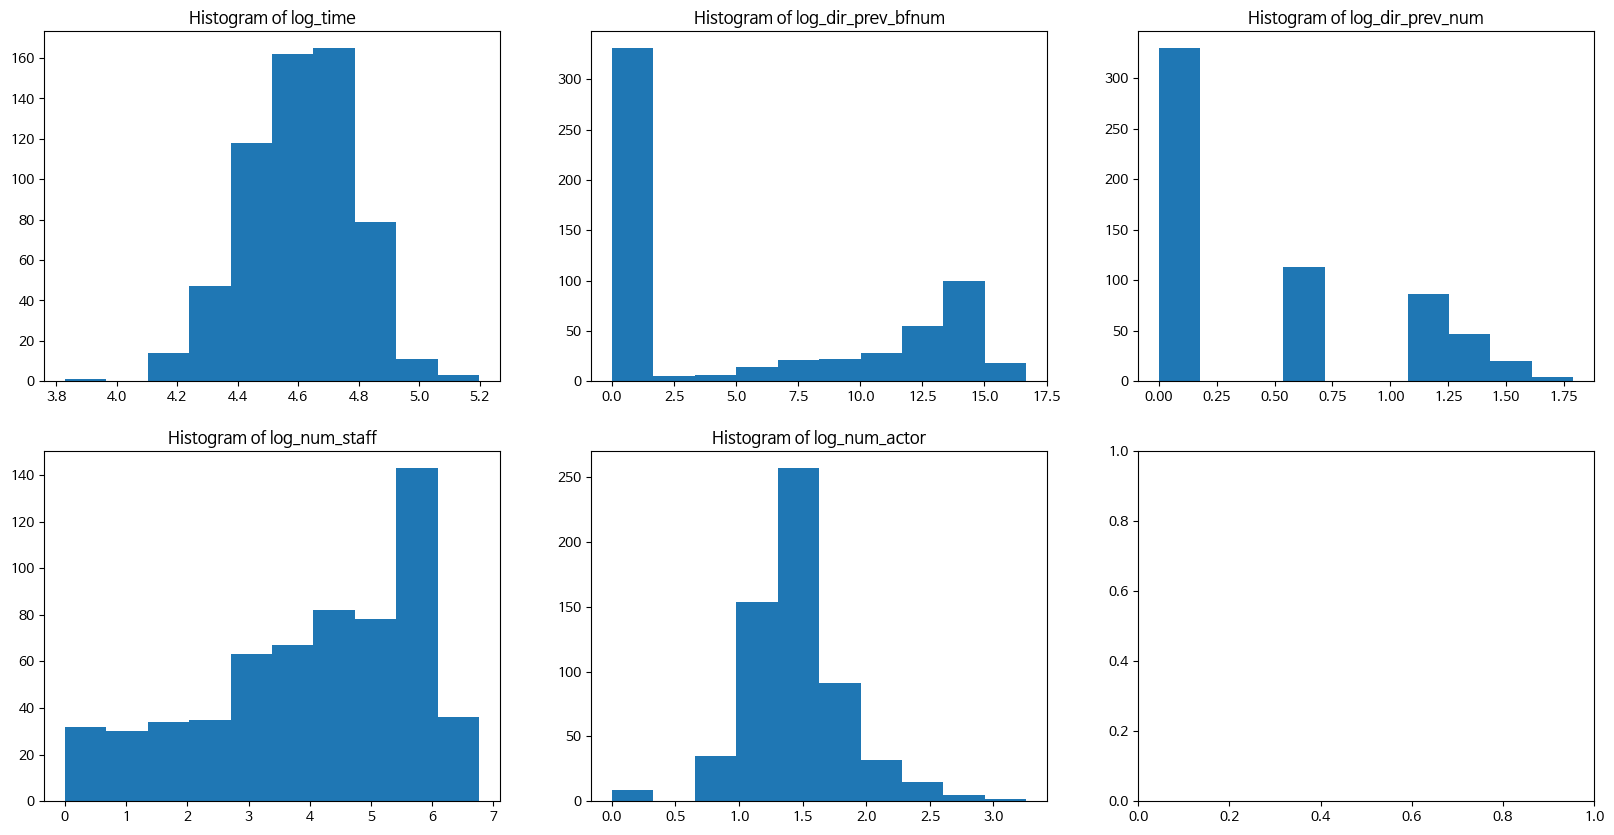

In [244]:
fig, axs = plt.subplots(figsize = (20, 10), nrows = 2, ncols = 3)
axs = np.ravel(axs)

for ind, feature in enumerate(log_conti_features):
  axs[ind].set_title(f"Histogram of {feature}")
  axs[ind].hist(X_features_log[feature])
  #sns.kdeplot(train[list[i]], fill = True)
  #plt.title(f"Density Plot of {list[i]}")
  #plt.xlabel(f"{list[i]}")

axs = np.reshape(axs, (2, 3))

'log_dir_prev_bfnum', 'log_num_staff', 'log_num_actor' 로그 변환한 거 사용

# 인코딩 & 로그 변환한 피처들 병합 -> 최종 X_features_final, X_test_final

피처 10개
* 카테고리형 변수 (director 삭제해서 5):
  1. 'distributor' -> X_features2['dist_abovemed']
  2. 'genre' -> X_features3['genre_rank']
  3. 'screening_rat' -> X_features3['screening_rat_rank']
  4. 'release_year' -> X_features4a['year_rank']
  5. 'release_month' -> X_features4a['month_rank']
* 연속형 변수 (5)
  1. 'time'
  2. 'dir_prev_bfnum' -> X_features_log['log_dir_prev_bfnum']
  3. 'dir_prev_num'
  4. 'num_staff' -> X_features_log['log_num_staff']
  5. 'num_actor' -> X_features_log['log_num_actor']

In [245]:
# title, box_off_num 삭제 아직 안 됨 (총 12개 칼럼)
X_features1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   dir_prev_bfnum  600 non-null    float64
 6   dir_prev_num    600 non-null    int64  
 7   num_staff       600 non-null    int64  
 8   num_actor       600 non-null    int64  
 9   box_off_num     600 non-null    int64  
 10  release_year    600 non-null    int64  
 11  release_month   600 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 56.4+ KB


In [246]:
X_features_final = X_features1[['time', 'dir_prev_num']].copy()
X_features_final.head()

,time,dir_prev_num
0,96,0
1,130,2
2,123,4
3,101,2
4,108,1


In [247]:
X_features_final = pd.concat([X_features_final, X_features2['dist_abovemed'],
                              X_features3['genre_rank'], X_features3['screening_rat_rank'],
                              X_features4a['year_rank'], X_features4a['month_rank'],
                              X_features_log['log_dir_prev_bfnum'], X_features_log['log_num_staff'],
                              X_features_log['log_num_actor']], axis=1)
print(X_features_final.info())
X_features_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                600 non-null    int64  
 1   dir_prev_num        600 non-null    int64  
 2   dist_abovemed       600 non-null    int64  
 3   genre_rank          600 non-null    int64  
 4   screening_rat_rank  600 non-null    int64  
 5   year_rank           600 non-null    int64  
 6   month_rank          600 non-null    int64  
 7   log_dir_prev_bfnum  600 non-null    float64
 8   log_num_staff       600 non-null    float64
 9   log_num_actor       600 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 47.0 KB
None


,time,dir_prev_num,dist_abovemed,genre_rank,screening_rat_rank,year_rank,month_rank,log_dir_prev_bfnum,log_num_staff,log_num_actor
0,96,0,4,3,3,2,6,0.000,4.522,1.099
1,130,2,2,4,3,4,6,13.965,5.961,1.386
2,123,4,2,3,1,1,10,12.305,5.841,1.609
3,101,2,3,2,4,2,3,10.081,3.045,1.946
4,108,1,10,2,1,6,6,0.693,5.529,1.099


In [248]:
X_test_final = X_test1[['time', 'dir_prev_num']].copy()
X_test_final = pd.concat([X_test_final, X_test2['dist_abovemed'],
                              X_test3['genre_rank'], X_test3['screening_rat_rank'],
                              X_test4a['year_rank'], X_test4a['month_rank'],
                              X_test_log['log_dir_prev_bfnum'], X_test_log['log_num_staff'],
                              X_test_log['log_num_actor']], axis=1)
print(X_test_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                243 non-null    int64  
 1   dir_prev_num        243 non-null    int64  
 2   dist_abovemed       243 non-null    int64  
 3   genre_rank          243 non-null    int64  
 4   screening_rat_rank  243 non-null    int64  
 5   year_rank           243 non-null    int64  
 6   month_rank          243 non-null    int64  
 7   log_dir_prev_bfnum  243 non-null    float64
 8   log_num_staff       243 non-null    float64
 9   log_num_actor       243 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 19.1 KB
None


# 레이블 인코딩, 랭크 인코딩, 로그 변환 비교

In [249]:
# 레이블 인코딩 적용한 피처 데이터 세트 기반으로 학습/예측 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features_le, log_y,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환, log 변환된거 고려하는
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  y_test = np.expm1(y_test)
  pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
ridge_reg = Ridge(alpha=10)
xgb = xgb.XGBRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)

for model in [ridge_reg, xgb, rf]:
  get_model_predict(model, X_train, X_test, y_train, y_test)

### Ridge ###
RMSE: 27262792.423, MAE: 3092286.657
### XGBRegressor ###
RMSE: 1599748.298, MAE: 528934.211
### RandomForestRegressor ###
RMSE: 1690444.943, MAE: 532514.580


In [250]:
# 랭크 인코딩 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_features_rank = X_features1[['time', 'dir_prev_num']].copy()
X_features_rank = pd.concat([X_features_rank, X_features2['dist_abovemed'],
                              X_features3['genre_rank'], X_features3['screening_rat_rank'],
                              X_features4a['year_rank'], X_features4a['month_rank'],
                              X_features1['dir_prev_bfnum'], X_features1['num_staff'],
                              X_features1['num_actor']], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features_rank, log_y,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환, log 변환된거 고려하는
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  y_test = np.expm1(y_test)
  pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
ridge_reg = Ridge(alpha=10)
xgb = xgb.XGBRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)

for model in [ridge_reg, xgb, rf]:
  get_model_predict(model, X_train, X_test, y_train, y_test)

### Ridge ###
RMSE: 10408723.641, MAE: 1526145.268
### XGBRegressor ###
RMSE: 1447234.452, MAE: 478613.240
### RandomForestRegressor ###
RMSE: 1613565.535, MAE: 507852.985


## 라벨 인코딩 -> 랭크 인코딩
```

비슷 except for ridge 규제

# 로그 변환

In [251]:
X_features_le_log = X_features_le.copy()
features_to_log = ['dir_prev_bfnum', 'num_staff', 'num_actor']
log_conti_features = ['log_dir_prev_bfnum', 'log_num_staff', 'log_num_actor']
X_features_le_log[log_conti_features] = np.log1p(X_features_le_log[features_to_log])
X_features_le_log.drop(['dir_prev_bfnum', 'num_staff', 'num_actor'], axis=1, inplace=True)
X_features_le_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   distributor         600 non-null    int64  
 1   genre               600 non-null    int64  
 2   time                600 non-null    int64  
 3   screening_rat       600 non-null    int64  
 4   dir_prev_num        600 non-null    int64  
 5   release_year        600 non-null    int64  
 6   release_month       600 non-null    int64  
 7   log_dir_prev_bfnum  600 non-null    float64
 8   log_num_staff       600 non-null    float64
 9   log_num_actor       600 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 47.0 KB


In [265]:
X_test_le_log = X_test_le.copy()
features_to_log = ['dir_prev_bfnum', 'num_staff', 'num_actor']
log_conti_features = ['log_dir_prev_bfnum', 'log_num_staff', 'log_num_actor']
X_test_le_log[log_conti_features] = np.log1p(X_test_le_log[features_to_log])
X_test_le_log.drop(['dir_prev_bfnum', 'num_staff', 'num_actor'], axis=1, inplace=True)
X_test_le_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   distributor         243 non-null    int64  
 1   genre               243 non-null    int64  
 2   time                243 non-null    int64  
 3   screening_rat       243 non-null    int64  
 4   dir_prev_num        243 non-null    int64  
 5   release_year        243 non-null    int64  
 6   release_month       243 non-null    int64  
 7   log_dir_prev_bfnum  243 non-null    float64
 8   log_num_staff       243 non-null    float64
 9   log_num_actor       243 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 19.1 KB


## 라벨 인코딩: 로그 변환 전 -> 후
```

In [252]:
# 레이블 인코딩과 로그변환 적용한 피처 데이터 세트 기반으로 학습/예측 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features_le_log, log_y,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환, log 변환된거 고려하는
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  y_test = np.expm1(y_test)
  pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
ridge_reg = Ridge(alpha=10)
xgb = xgb.XGBRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)

for model in [ridge_reg, xgb, rf]:
  get_model_predict(model, X_train, X_test, y_train, y_test)

### Ridge ###
RMSE: 1878981.124, MAE: 589155.150
### XGBRegressor ###
RMSE: 1599860.133, MAE: 529372.283
### RandomForestRegressor ###
RMSE: 1689674.399, MAE: 531494.362


## 랭크 인코딩: 로그 변환 전 -> 후

In [253]:
# 랭크 인코딩과 로그변환 적용한 피처 데이터 세트 기반으로 학습/예측 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features_final, log_y,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환, log 변환된거 고려하는
def get_model_predict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  y_test = np.expm1(y_test)
  pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
ridge_reg = Ridge(alpha=10)
xgb = xgb.XGBRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)

for model in [ridge_reg, xgb, rf]:
  get_model_predict(model, X_train, X_test, y_train, y_test)

### Ridge ###
RMSE: 2026926.618, MAE: 580506.905
### XGBRegressor ###
RMSE: 1447234.452, MAE: 478613.240
### RandomForestRegressor ###
RMSE: 1614146.867, MAE: 508576.490


#### 이상치 확인

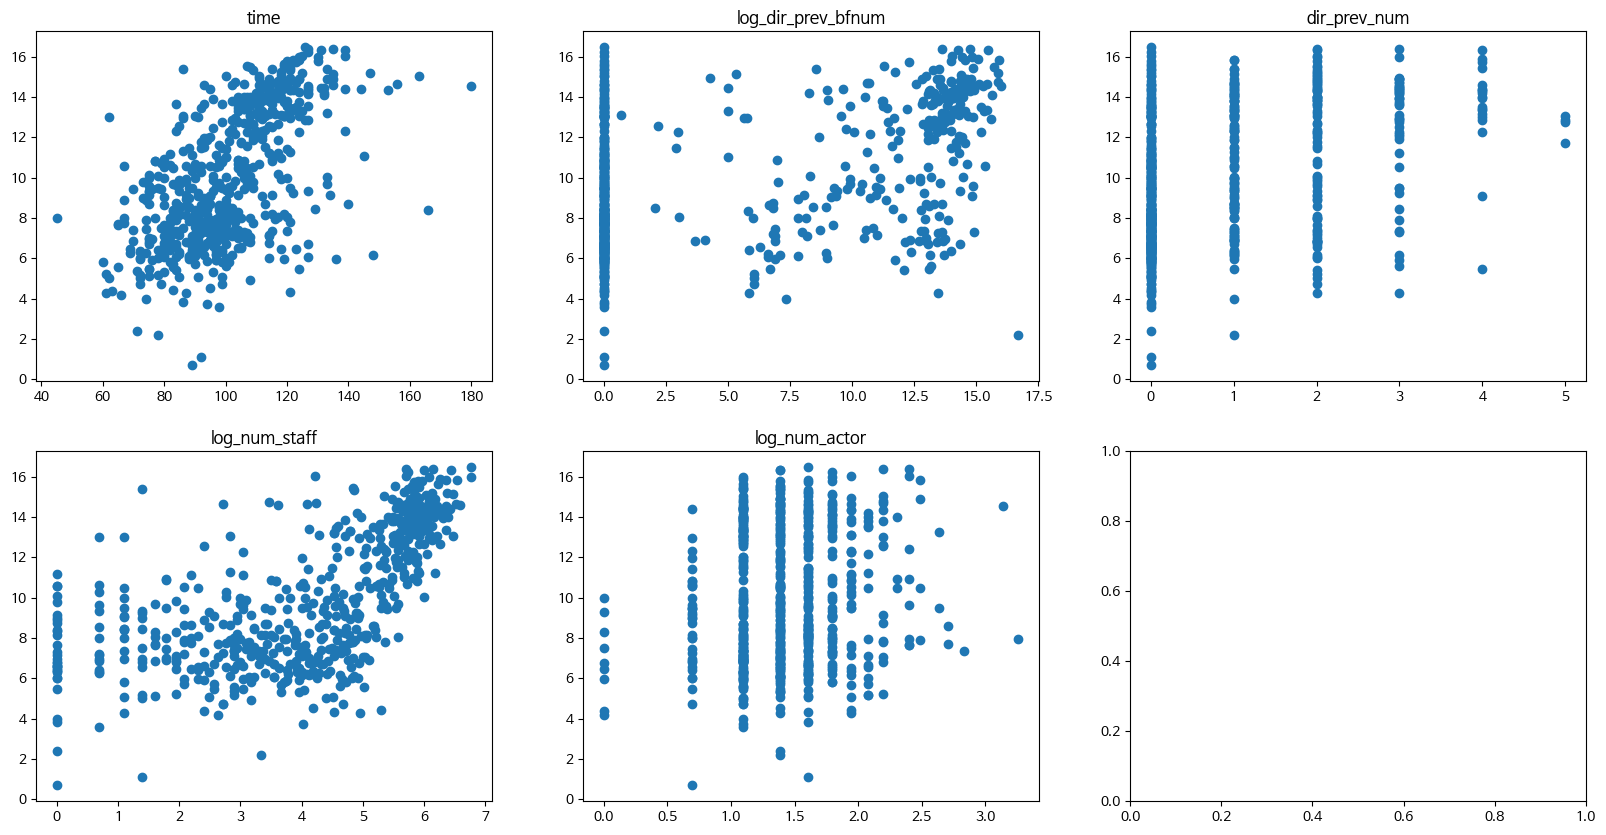

In [255]:
conti_features = ['time', 'log_dir_prev_bfnum', 'dir_prev_num', 'log_num_staff', 'log_num_actor']

#import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (20, 10), nrows = 2, ncols = 3)
axs = np.ravel(axs)

for ind, feature in enumerate(conti_features):
  axs[ind].set_title(f"{feature}")
  axs[ind].scatter(x=X_features_le_log[feature], y=log_y)

axs = np.reshape(axs, (2, 3))

제거할 만한 이상치 딱히 없음

# 레이블 인코딩된 데이터로 XGB, LGBM

In [256]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgb_reg = xgb.XGBRegressor(random_state=0)
clf = GridSearchCV(estimator=xgb_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X_features_le_log, log_y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Lowest RMSE:  1.830362117770254


In [257]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [2,3,4,5],
           'learning_rate': [0.01, 0.1, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.6, 0.7, 0.8),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [800,1000,1200]}
xgb_reg = xgb.XGBRegressor(random_state=0)
clf = RandomizedSearchCV(estimator=xgb_reg,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(X_features_le_log, log_y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.5, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8999999999999999}
Lowest RMSE:  1.8081129031577439


In [258]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

params = {'num_leaves':[2,3,4,5],
          'colsample_bytree': np.arange(0.6, 0.7, 0.8),
          'reg_lambda':[6,7,8,9,10,11],
          'subsample':np.arange(0.6,0.8,0.9),
          'n_estimators': [100,300,500,700,1000]}
lgbm_reg = LGBMRegressor(random_state=0)
clf = GridSearchCV(estimator=lgbm_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X_features_le_log, log_y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 10
[LightGBM] [Info] Start training from score 9.848853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 10
[LightGBM] [Info] Start training from score 9.998665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413


XGB Best parameters: 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500

Lowest RMSE:  1.83

LGBM Best parameters: {'colsample_bytree': 0.6, 'n_estimators': 500, 'num_leaves': 5, 'reg_lambda': 11, 'subsample': 0.6}

Lowest RMSE:  1.8234351706925038

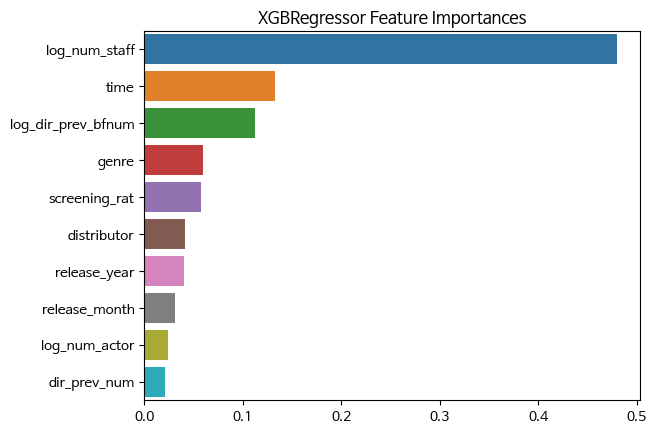

In [259]:
xgb_reg = xgb.XGBRegressor(random_state=0,
                          colsample_bytree = 0.7,
                          learning_rate = 0.05,
                          max_depth = 3,
                          n_estimators = 500)
xgb_reg.fit(X_features_le_log, log_y)
XGB_feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_features_le_log.columns)
XGB_feature_series = XGB_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=XGB_feature_series, y=XGB_feature_series.index)
plt.title("XGBRegressor Feature Importances")
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 10
[LightGBM] [Info] Start training from score 9.951971


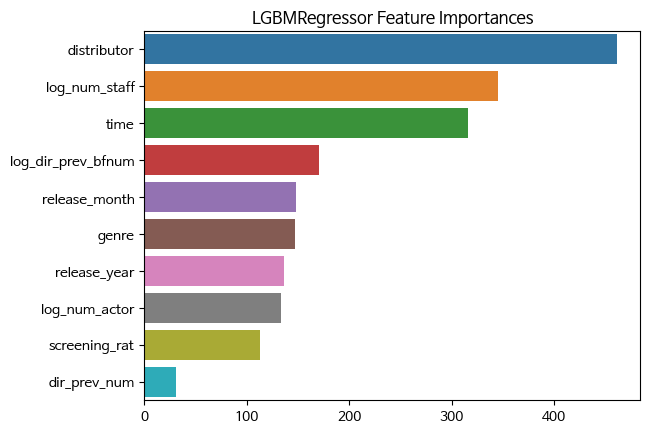

In [260]:
lgbm_reg = LGBMRegressor(random_state=0,
                         colsample_bytree = 0.6,
                         n_estimators = 500,
                         num_leaves = 5,
                         reg_lambda = 11,
                         subsample = 0.6)
lgbm_reg.fit(X_features_le_log, log_y)

LGBM_feature_series = pd.Series(data=lgbm_reg.feature_importances_, index=X_features_le_log.columns)
LGBM_feature_series = LGBM_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=LGBM_feature_series, y=LGBM_feature_series.index)
plt.title("LGBMRegressor Feature Importances")
plt.show()

In [267]:
xgb_pred = xgb_reg.predict(X_test_le_log)
lgbm_pred = lgbm_reg.predict(X_test_le_log)

xgb1 = submission.copy()
xgb1['box_off_num'] = np.expm1(xgb_pred)
xgb1.to_csv('xgb_last.csv', index=False)

lgbm1 = submission.copy()
lgbm1['box_off_num'] = np.expm1(lgbm_pred)
lgbm1.to_csv('lgbm_last.csv', index=False)

점수
* XGB: 1195838
* LGBM: 1510157


## 혼합

In [269]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred_mix2 = 0.5*xgb_pred + 0.5*lgbm_pred

sub_mix2 = submission.copy()
sub_mix2['box_off_num'] = np.expm1(pred_mix2)
sub_mix2.to_csv('label_mix.csv', index=False)

점수
* XGB: 1433055.0212258615
* LGBM: 1632879.1382837642
* XGB + LGBM: 1504566.3355769124

# 랭킹 인코딩된 데이터로 XGB, RF

GridSearchCV, scoring = -MSE

In [270]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgb_reg = xgb.XGBRegressor(random_state=0)
clf = GridSearchCV(estimator=xgb_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X_features_final, log_y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  1.7378226019830754


RandomizedSearchCV, scoring = -MSE

In [271]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [2,3,4,5],
           'learning_rate': [0.01, 0.1, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.6, 0.7, 0.8),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [800,1000,1200]}
xgb_reg = xgb.XGBRegressor(random_state=0)
clf = RandomizedSearchCV(estimator=xgb_reg,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(X_features_final, log_y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.5, 'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}
Lowest RMSE:  1.7225589700660615


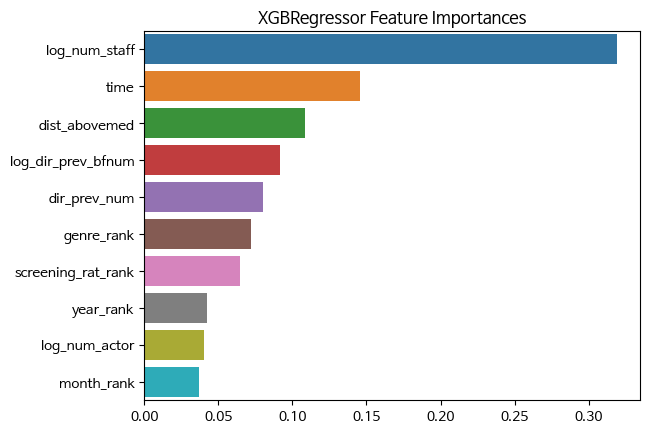

In [ ]:
xgb_reg = xgb.XGBRegressor(random_state=0,
                           subsample = 0.7, n_estimators = 1000,
                           max_depth = 4, learning_rate = 0.01,
                           colsample_bytree = 0.6, colsample_bylevel = 0.7)
xgb_reg.fit(X_features_final, log_y)
XGB_feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_features_final.columns)
XGB_feature_series = XGB_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=XGB_feature_series, y=XGB_feature_series.index)
plt.title("XGBRegressor Feature Importances")
plt.show()

In [ ]:
xgb_pred = xgb_reg.predict(X_test_final)
xgb_rank = submission.copy()
xgb_rank['box_off_num'] = np.expm1(xgb_pred)
xgb_rank.to_csv('xgb_rank.csv', index=False)

점수: 1350161

No tuning

In [137]:
xgb_reg_notuning = xgb.XGBRegressor(random_state=0)
xgb_reg_notuning.fit(X_features_final, log_y)
xgb_pred_notuning = xgb_reg_notuning.predict(X_test_final)
xgb_rank_notuning = submission.copy()
xgb_rank_notuning['box_off_num'] = np.expm1(xgb_pred_notuning)
xgb_rank_notuning.to_csv('xgb_rank_notuning.csv', index=False)

점수: 1262852

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, random_state=0)
rf.fit(X_features_final, log_y)
rf_pred = rf.predict(X_test_final)
rf1 = submission.copy()
rf1['box_off_num'] = np.expm1(rf_pred)
rf1.to_csv('rf_rank_notuning.csv', index=False)

점수: 1349528

## 혼합

In [138]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출
xgb_rf_mix_pred = 0.6*xgb_pred_notuning + 0.4*rf_pred

xgb_rf_mix = submission.copy()
xgb_rf_mix['box_off_num'] = np.expm1(xgb_rf_mix_pred)
xgb_rf_mix.to_csv('xgb_rf_mix.csv', index=False)

점수
* XGB + RF: 1209920.4483750137

# 가장 점수 좋았던 두 예측데이터 혼합

In [151]:
xgb1 = pd.read_csv('/content/xgb1.csv', sep = ',')
xgb1.head()

,title,box_off_num
0,용서는 없다,1949332.100
1,아빠가 여자를 좋아해,1057755.000
2,하모니,164163.310
3,의형제,1319058.000
4,평행 이론,3157634.000


In [152]:
xgb_rf_mix.head()

,title,box_off_num
0,용서는 없다,2414378.068
1,아빠가 여자를 좋아해,957422.346
2,하모니,404667.462
3,의형제,1746350.571
4,평행 이론,1566820.704


In [153]:
doublemix = submission.copy()
doublemix['box_off_num'] = 0.5*xgb1['box_off_num'] + 0.5*xgb_rf_mix['box_off_num']
doublemix.to_csv('doublemix.csv', index=False)

1152640.1291768963